This script tries to classify 75 Butterfly Species. The used dataset is the one below:

https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification

An accuracy of about 80% is reached using feature extractor ResNet101 from:

He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

Article Reference https://arxiv.org/abs/1512.03385

A four layers Fully Conneted Neural Network is plugged as output classifier

In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import os

import torch
!pip install torchsummary
from torchsummary import summary
from torch import nn
from torchvision.io import read_image
import torchvision
import torchvision.transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

In [2]:
class ButterflyDS(Dataset):
    
    def __init__(self, path, csv_path):
        self.image_class = {}
        self.image_feature = []
        self.image_label = []
        self.index = 0
        self.label_to_index = {}
        self.transform = torchvision.transforms.Resize((100,100), antialias=None)
        self.data_aug_transform =  torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.GaussianBlur(kernel_size=(11,11), sigma=(0.05, 2)),
            torchvision.transforms.RandomAffine(0, shear=10,scale=(0.8, 1.2))])
        with open(csv_path) as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            next(reader)
            for row in reader:
                self.image_class[row[0]] = row[1]
                if row[1] not in self.label_to_index:
                    self.label_to_index[row[1]] = self.index
                    self.index += 1
        for image in os.listdir(path):
            try:
                self.image_label.append(int(self.label_to_index[self.image_class[image]]))
                tmp_img = read_image(path+image)
                tmp_img = self.transform(tmp_img/255.0)
                self.image_feature.append(tmp_img)
            except:
                pass
        tmp_set = []
        for index in range(len(self.image_feature)):
            tmp_set.append(self.data_aug_transform(self.image_feature[index]))
            self.image_label.append(self.image_label[index])
        self.image_feature = self.image_feature + tmp_set
            
    def __len__(self):
        return len(self.image_feature)
    
    def __getitem__(self, index):
        return self.image_feature[index], self.image_label[index]

In [3]:
dataset_path = '/kaggle/input/butterfly-image-classification/train/'
label_path = '/kaggle/input/butterfly-image-classification/Training_set.csv'

data_cache = ButterflyDS(dataset_path, label_path)

In [4]:
print(len(data_cache))

12998


In [5]:
split_ratio = 0.95
train_set_len = int(len(data_cache)*split_ratio)
test_set_len = len(data_cache)-train_set_len

train_set, val_set = torch.utils.data.random_split(data_cache, [train_set_len, test_set_len])



In [6]:
print(len(train_set))
print(len(val_set))

12348
650


In [7]:
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=1, shuffle=True)

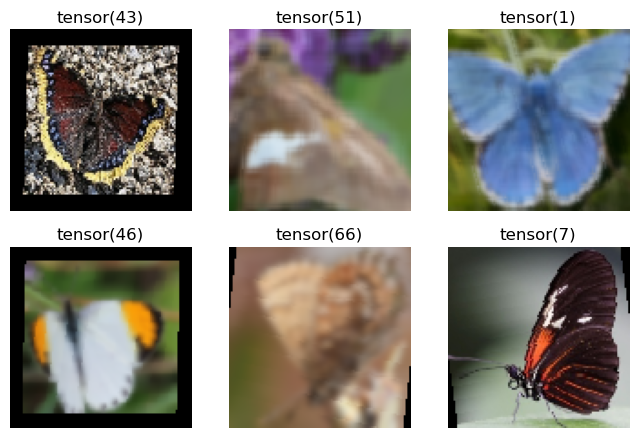

In [8]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
i = 1
for train_features, train_labels in train_dataloader:
    img = train_features[0].numpy().astype('float')
    label = train_labels[0]
    img = torch.permute(Variable(torch.Tensor(img)), (1,2,0)).numpy().astype('float')
    figure.add_subplot(rows, cols, i)
    i += 1
    plt.title(label)
    plt.axis("off")
    plt.imshow(img)
    if i==7:
        break  
plt.show()
print()

In [9]:
model  = torchvision.models.resnet101(weights='IMAGENET1K_V1')


for param in model.parameters():
    param.requires_grad = False   
    
classes=75

model.fc  = nn.Sequential(
    nn.Linear(2048 , 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024 , 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024 , 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, classes))
#summary(model, (3, 100, 100))

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 254MB/s]


In [10]:
acc = []
loss_list = []

def train_network(dataloader, nn_model, loss_fn_in, optimizer_in):
    size = len(dataloader.dataset)
    nn_model.train()
    for batch, (X,Y) in enumerate(dataloader):
    #FORWARD
        prediction = nn_model(X)
        loss = loss_fn_in(prediction, Y)
        #BACKWARD PROP
        loss.backward()
        optimizer_in.step()
        optimizer_in.zero_grad()
        if batch%10 == 0:
            loss_list.append(loss)
            current = (batch+1)*len(X)
            print(f"loss: {loss:>7f},   [{current:>5d}/{size:>5d}]")

def test_network(dataloader, nn_model, loss_fn_in):
    nn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for val_features, val_label in dataloader:
            total += 1
            y_pred = model(val_features)
            y_pred_class = y_pred.argmax()
            if int(y_pred_class) == int(val_label):
                correct += 1
        acc.append( float(correct)/ float(total)*100)
        print(f"Test Accuracy: {acc[-1]:.4f}%")
        print("-------------------------------------")
        scheduler.step()

In [11]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model.parameters(), lr=5e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
epochs = 60
for t in range(epochs):
    print(f"EPOCH: {t+1}\n------------")
    train_network(train_dataloader, model, criterion, optimizer_ft)
    test_network(val_dataloader, model, criterion)
print("Done!!!")

EPOCH: 1
------------
loss: 4.484641,   [  128/12348]
loss: 3.025735,   [ 1408/12348]
loss: 2.502343,   [ 2688/12348]
loss: 2.082253,   [ 3968/12348]
loss: 1.851847,   [ 5248/12348]
loss: 1.491984,   [ 6528/12348]
loss: 1.685982,   [ 7808/12348]
loss: 1.453937,   [ 9088/12348]
loss: 1.438983,   [10368/12348]
loss: 1.269519,   [11648/12348]
Test Accuracy: 71.2308%
-------------------------------------
EPOCH: 2
------------
loss: 0.831957,   [  128/12348]
loss: 0.860650,   [ 1408/12348]
loss: 0.917573,   [ 2688/12348]
loss: 0.986865,   [ 3968/12348]
loss: 0.856618,   [ 5248/12348]
loss: 0.796137,   [ 6528/12348]
loss: 1.014898,   [ 7808/12348]
loss: 0.980020,   [ 9088/12348]
loss: 0.872428,   [10368/12348]
loss: 0.795533,   [11648/12348]
Test Accuracy: 73.8462%
-------------------------------------
EPOCH: 3
------------
loss: 0.633064,   [  128/12348]
loss: 0.669780,   [ 1408/12348]
loss: 0.545497,   [ 2688/12348]
loss: 0.491377,   [ 3968/12348]
loss: 0.636905,   [ 5248/12348]
loss: 0.52

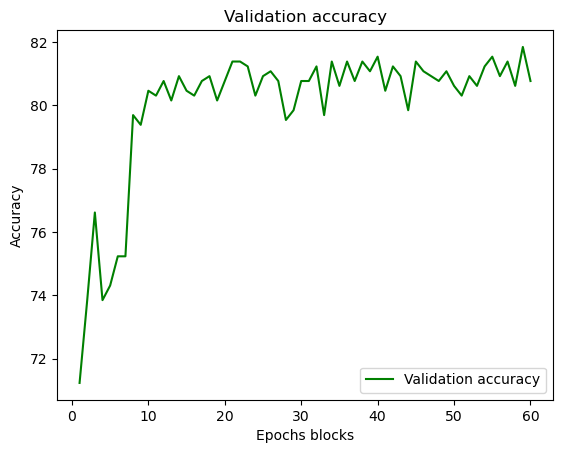

In [13]:
epochs_acc = range(1,len(acc)+1)
plt.plot(epochs_acc, acc, 'g', label='Validation accuracy')
plt.title('Validation accuracy')
plt.xlabel('Epochs blocks')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

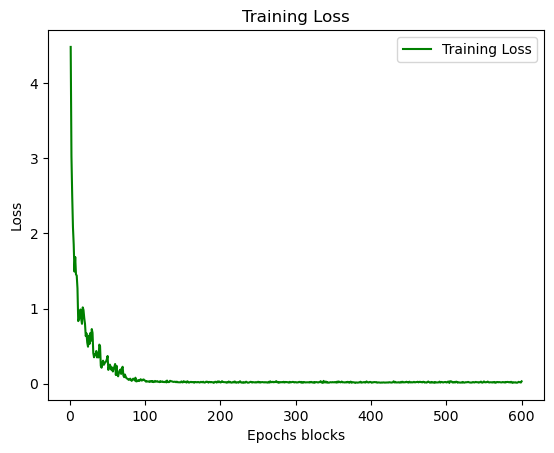

In [14]:
loss_list = [item.detach().numpy() for item in loss_list]
epochs_loss = range(1,len(loss_list)+1)
plt.plot(epochs_loss, loss_list, 'g', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs blocks')
plt.ylabel('Loss')
plt.legend()
plt.show()